In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
import scipy.stats
import timeit
%matplotlib inline

In [2]:
ori = scipy.io.loadmat('../data/week3/DirectionTuning_V1_dec.mat',struct_as_record=True)
noff = ori['dirTuningExp']['stimOffFrames'][0][0][0][0]
non = ori['dirTuningExp']['stimOnFrames'][0][0][0][0]
ntrial = ori['dirTuningExp']['nTrials'][0][0][0][0]
# test_dir1 = ori['dirTuningExp']['tGratingDirectionDeg'][0][0][0][79][0][0]
noff, non, ntrial, #test_dir1

(12, 6, 80)

In [3]:
data = ori['data']
off = np.zeros([data.shape[0],data.shape[1],noff,ntrial])
on = np.zeros([data.shape[0],data.shape[1],non,ntrial])

for i in np.arange(ntrial):
    chunk = data[:, :, i*(noff+non):(i+1)*(noff+non)]
    off[:,:,:,i] = chunk[:,:, 0:noff]
    on[:,:,:,i] = chunk[:,:, noff:noff+non]

off_avg = np.mean(off, axis=2)
on_avg = np.mean(on, axis=2)
diff_img = on_avg - off_avg

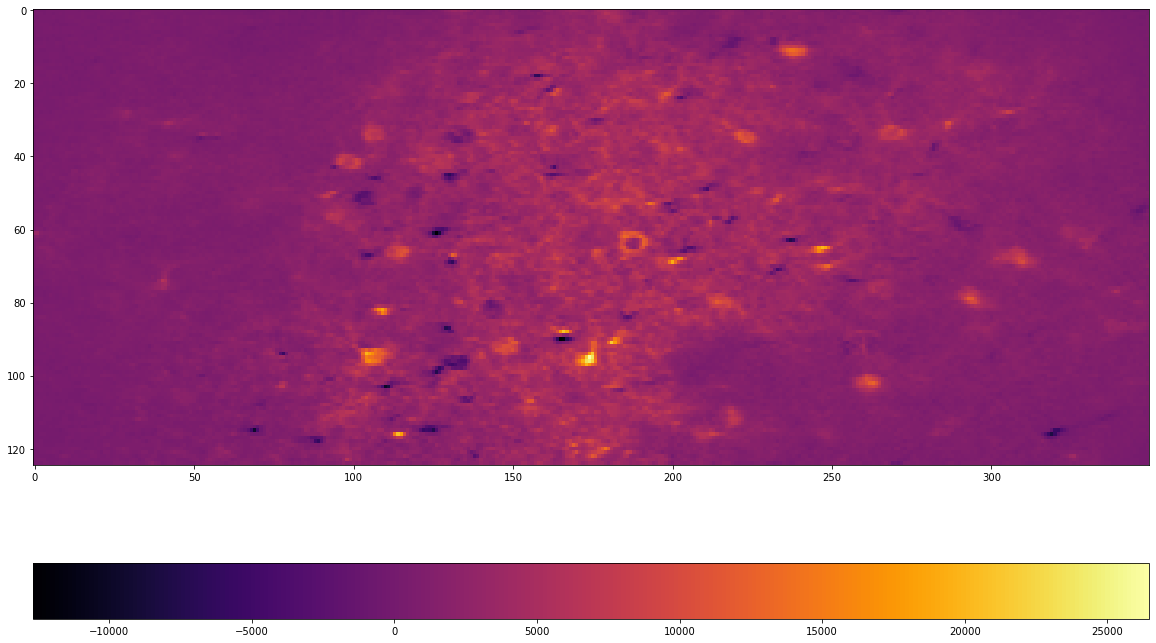

In [4]:
# test_diff = np.mean(diff_img, axis=2)
test_diff = diff_img[:,:,0]
test_on = np.mean(on_avg, axis=2)
test_off = np.mean(off_avg, axis=2)

plt.figure(figsize=(20,12))
# plt.subplot(131)
plt.imshow(test_diff, aspect='auto', cmap='inferno'); plt.colorbar(orientation="horizontal");
# plt.subplot(132)
# plt.imshow(test_on); plt.colorbar(orientation="horizontal");
# plt.subplot(133)
# plt.imshow(test_off); plt.colorbar(orientation="horizontal");
# plt.tight_layout()

In [5]:
dir_seq = np.zeros_like(np.arange(ntrial))
for i in np.arange(ntrial):
    dir_seq[i] = ori['dirTuningExp']['tGratingDirectionDeg'][0][0][0][[i]][0][0][0]    
ndir = len(np.unique(dir_seq))

# # this also works:
# dirs = []
# [dirs.append(ori['dirTuningExp']['tGratingDirectionDeg'][0][0][0][[i]][0][0][0]) for i in np.arange(ntrial)]

In [6]:
def pixel_tuning(i,j):
    
    if i > ori['data'].shape[0] or j > ori['data'].shape[1]:
        print('pixel out of range')
        return None
    
    dir_resp = []
    dir_img = np.zeros_like(diff_img[:,:,np.arange(ndir)])
    
    for direction in np.unique(dir_seq):
        idir = np.where(np.unique(dir_seq) == direction)[0][0]
        itrial = np.where(dir_seq == direction)
        dir_img[:,:,np.where(np.unique(dir_seq) == direction)[0][0]] = np.mean(np.squeeze(diff_img[:,:,itrial]), axis=2)
        dir_resp.append(np.squeeze(diff_img[:,:,itrial])[i,j,:])
    _, p = scipy.stats.f_oneway(dir_resp[0], dir_resp[1], dir_resp[2], dir_resp[3], dir_resp[4], dir_resp[5], dir_resp[6], dir_resp[7])
#     _, p = scipy.stats.f_oneway(np.squeeze(on_avg[0,0,:]), np.squeeze(off_avg[0,0,:]))
    
    if p >= 0.05:
        return np.NaN # pixel is untuned bc of ANOVA
    
    elif p < 0.05:
        dir_pref_index = np.argmax(dir_img[i,j,:])
        dir_orth_index = dir_pref_index + ndir/2
        if dir_orth_index > ndir-1:
            dir_orth_index = dir_orth_index - ndir
        dir_pref_resp = np.max(dir_img[i,j,:])
        dir_orth_resp = dir_img[i,j,int(dir_orth_index)]
        R = 1 - dir_orth_resp / dir_pref_resp
        
        if R > 0.33:
            return np.unique(dir_seq)[dir_pref_index] 
        else:
            return np.NaN # pixel is untuned bc of R

In [17]:
img_pref = np.zeros_like(ori['data'][:,:,0]); img_pref[:] = np.nan

In [ ]:
%%timeit
for i in np.arange(ori['data'].shape[0]):
    for j in np.arange(ori['data'].shape[1]):
        img_pref[i,j] = pixel_tuning(i,j)
# %store img_pref

In [9]:
# %store -r
# img_pref_stored = img_pref.copy()
# (unique, counts) = np.unique(img_pref[~np.isnan(img_pref)], return_counts=True)
# frequencies = np.asarray((unique, counts)).T
# frequencies

array([[   0., 1868.],
       [  45.,   31.],
       [  90.,   76.],
       [ 135.,    9.],
       [ 180.,    8.],
       [ 225.,  423.],
       [ 270.,   15.],
       [ 315.,    7.]])

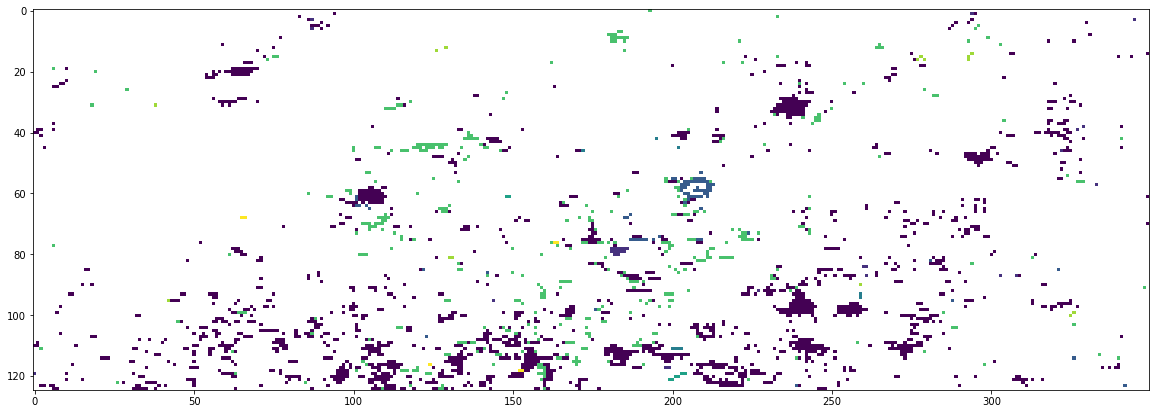

In [13]:
plt.figure(figsize=(20,7))
plt.imshow(img_pref, aspect='auto', cmap=plt.cm.get_cmap('viridis', ndir))
# plt.colorbar(); # cannot show colorbar without hiding the main plot, for some reason
plt.show()

In [299]:
import time
start = time.time()
for counter in range(10):
    for i in np.arange(subset.shape[0]):
        for j in np.arange(subset.shape[1]):
            img_pref_test[i,j] = pixel_tuning(i,j)
    counter = counter + 1
end = time.time()
print ("Time elapsed:", end - start)

Time elapsed: 24.55374503135681


In [297]:
import time
start = time.time()
for counter in range(10):
    for i in np.arange(subset.shape[1]):
        for j in np.arange(subset.shape[0]):
            img_pref_test[j,i] = pixel_tuning(j,i)
    counter = counter + 1
end = time.time()
print ("Time elapsed:", end - start)

Time elapsed: 25.17357063293457


looping over rows in the outer loop seems faster, perhaps because numpy stores data in row major order

In [58]:
%prun pixel_tuning(30,240)

         948 function calls (946 primitive calls) in 0.181 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.162    0.162    0.178    0.178 <ipython-input-29-8eff3482620b>:1(pixel_tuning)
       31    0.008    0.000    0.008    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.003    0.003    0.181    0.181 <string>:1(<module>)
    92/90    0.003    0.000    0.014    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
       18    0.001    0.000    0.001    0.000 {built-in method numpy.empty}
        9    0.001    0.000    0.009    0.001 _methods.py:143(_mean)
       16    0.001    0.000    0.001    0.000 <__array_function__ internals>:2(squeeze)
       18    0.000    0.000    0.002    0.000 arraysetops.py:309(_unique1d)
        1    0.000    0.000    0.001    0.001 stats.py:3534(f_oneway)
       18    0.000    0.000    0.002    0.000 arraysetops.py:149(unique)
        8 

Where does your code spend most of its time?  
method 'reduce' of 'numpy.ufunc' objects  
  
What piece of the code would you need to speed up in order to improve performance?  
parallel computation of preferred direction of different pixels  

How might you do this?  
distribute computation tasks to many running kernels?  

In [14]:
def pixel_tuning_flat(n): # rewriting function pixel_tuning to flatten pixel coordination selection
    
    import numpy as np
    import scipy.stats
    
    j = n % data.shape[1]
    i = n // data.shape[1]
    ndir = len(np.unique(dir_seq))
    
    dir_resp = []
    dir_img = np.zeros_like(diff_img[:,:,np.arange(ndir)])
    
    for direction in np.unique(dir_seq):
        idir = np.where(np.unique(dir_seq) == direction)[0][0]
        itrial = np.where(dir_seq == direction)
        dir_img[:,:,np.where(np.unique(dir_seq) == direction)[0][0]] = np.mean(np.squeeze(diff_img[:,:,itrial]), axis=2)
        dir_resp.append(np.squeeze(diff_img[:,:,itrial])[i,j,:])
    _, p = scipy.stats.f_oneway(dir_resp[0], dir_resp[1], dir_resp[2], dir_resp[3], dir_resp[4], dir_resp[5], dir_resp[6], dir_resp[7])
#     _, p = scipy.stats.f_oneway(np.squeeze(on_avg[0,0,:]), np.squeeze(off_avg[0,0,:]))
    
    if p >= 0.05:
        return np.NaN # pixel is untuned bc of ANOVA
    
    elif p < 0.05:
        dir_pref_index = np.argmax(dir_img[i,j,:])
        dir_orth_index = dir_pref_index + ndir/2
        if dir_orth_index > ndir-1:
            dir_orth_index = dir_orth_index - ndir
        dir_pref_resp = np.max(dir_img[i,j,:])
        dir_orth_resp = dir_img[i,j,int(dir_orth_index)]
        R = 1 - dir_orth_resp / dir_pref_resp
        
        if R > 0.33:
            return np.unique(dir_seq)[dir_pref_index] 
        else:
            return np.NaN # pixel is untuned bc of R

In [15]:
import ipyparallel as ipp
client = ipp.Client()
print("Number of ipyparallel engines:", len(client.ids))
dview = client[:]

Number of ipyparallel engines: 4


In [ ]:
client = ipp.Client()
dview = client[:]

dview.push({'pixel_tuning_flat': pixel_tuning_flat})
dview.push(dict(ori=ori, data=data, dir_seq=dir_seq, diff_img=diff_img)) 

# import time
# start = time.time()
# t = list(dview.map_sync(lambda n:pixel_tuning_flat(n), range(N)))
# end = time.time()
# print ("Time elapsed:", end - start)

In [ ]:
%%timeit
t = list(dview.map_sync(lambda n:pixel_tuning_flat(n), range(N)))

How big a speedup did you get? (Make sure not to time the setup steps.)  
n times faster

We would naively expect the computation time to be, e.g., 4x smaller with four workers. Why might your answer differ from this?  
the speed is not 4 times faster because a) it takes some time to split the workload, distribute it to different engines, recollect and merge the results from them. this creates an extra lag. and b) in distributed programming in python, "code dependencies are not transferred for you! This includes modules, functions, and variables", so we have to import the libraries again in our function being iterated. 

https://achidlow.github.io/blog/2013/09/24/distributed-computing-with-ipython/

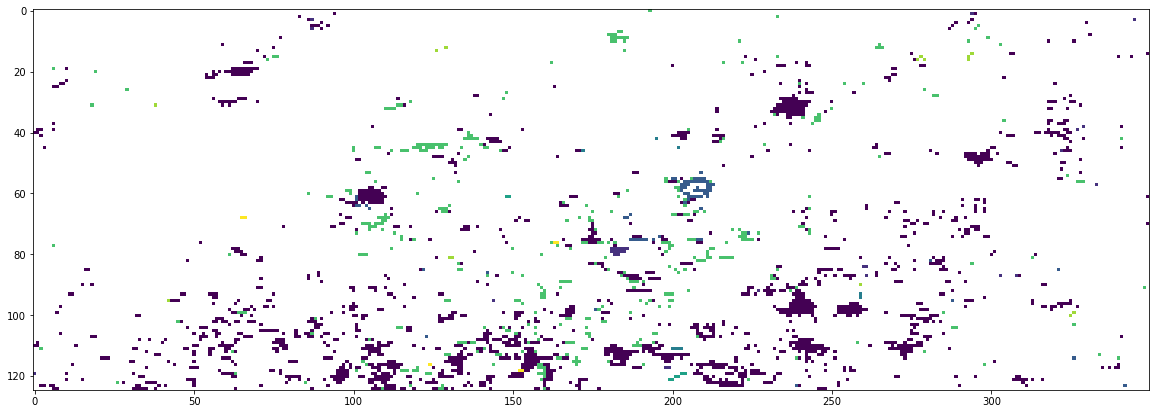

In [43]:
tt = np.array(t).reshape((ori['data'].shape[0], ori['data'].shape[1]))
plt.figure(figsize=(20,7))
plt.imshow(tt, aspect='auto', cmap=plt.cm.get_cmap('viridis', ndir))
# plt.colorbar(); # cannot show colorbar without hiding the main plot, for some reason
plt.show()